In [2]:
#@title Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
import os.path
from os import path
import pickle
from scipy import stats
from sklearn.decomposition import FastICA

In [3]:
# if your data is not in Colab, click on 'mount Drive' under Files on the left

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#@title Functions we need
def load_all_timestamps_of_trials(drivepath):
  '''
  Simply loads all the time_stamped arrays from all trials in the order they occur relative to each other.
  each array is of size [nTrials,]

  Input: drivepath (file location)
  Output: trial_times, vis_stim, goCue, resp_times, feedback_times
  '''
  trial_times = np.load(drivepath+'trials.intervals.npy') # in seconds. stim starts after wheel was still for 1.5 s
  vis_stim = np.load(drivepath+'trials.visualStim_times.npy')
  goCue = np.load(drivepath+'trials.goCue_times.npy') # in seconds, this is after seeing the stimulus. now the mouse can move the wheel which is now coupled ot the stim location
  resp_times = np.load(drivepath+'trials.response_times.npy')
  feedback_times = np.load(drivepath+'trials.feedback_times.npy') # is shortly before end of interval (trial_times[:,1])
  
  # During the 1 s feedback period, the visual stimulus remained on the screen. After a subsequent inter-trial interval of 1 s, [...from paper]
  return trial_times, vis_stim, goCue, resp_times, feedback_times

# PCA analysis
def smoothHist(hist, binsize, SD):
  '''
  to smooth single spike trains
  input:  hist: spike train, size: [nNeurons
  '''
  edges = np.arange(-3.0*SD, 3.0*SD, binsize)
  kernel = (1.0/(6.0*(SD**2)))*((np.sqrt(6.0)*SD)-np.abs(edges)) # a triangular kernel
  m = np.min(kernel) 
  kernel = kernel + np.abs(m)
  kernel = kernel/np.sum(kernel)
  half_length = int((len(kernel)-1)/2)
  
  smHist = []
  
  for celli in range(np.shape(hist)[0]):
    row = hist[celli,:]
    temp = np.convolve(row, kernel)   
    smHist.append(temp[half_length:-1-half_length])
  
  return np.array(smHist)

def concatenate_trials(input_dict, pick): 
 # functions to concatenate trials if the input is dictionary
 # expected input is of shape like output of getHistTrials
 
  keys = np.array(list(spikes.keys()))
  no_trials, _ = np.shape(keys) 
  no_neurons = np.shape(input_dict[0,pick])[0]
  out = input_dict[0,pick] # first trial
  for trials in np.arange(1, int(no_trials/4)):
    out = np.concatenate([out, input_dict[trials,pick]], axis = 1) # concatenating 

  return out

def concatenate_trials_by_feedbackoutput(spikes_hist, pick, feedback, correct=True): 
 # functions to concatenate trials if the input is dictionary
 # expected input is of shape like output of getHistTrials
  
  keys = np.array(list(spikes_hist.keys()))
  no_trials, _ = np.shape(keys)
  out = spikes_hist[0,pick] # first trial
  if correct:
    target_val = 1
  else:
    target_val = -1

  for trials in np.arange(1, int(no_trials/4)):
    if feedback[trials]==target_val:
      out = np.concatenate([out, spikes_hist[trials,pick]], axis = 1) # concatenating 

  return out

def ReactStrength(Qref,Qtar, method = 'PCA'):
  """
  inputs:       Qref binned spike train during the reference epoch (neurons x time)
                Qtar binned spike train during the target    epoch (neurons x time)

  """
  nCells = np.shape(Qref)[0]
  if nCells != np.shape(Qtar)[0]:
    error('''Qred'' and ''Qtar'' should have the same number of rows''') 

  Cref = np.corrcoef(Qref) # neuron x neuron
  lambdas, PCs  = np.linalg.eigh(Cref)
  lambdas = np.flip(lambdas)
  PCs     = np.flip(PCs, axis=1)
  #Marcenko-Pastur threshold
  lMax = (1 + np.sqrt(nCells / np.shape(Qref)[1]))**2

  nPCs     = np.sum(lambdas>lMax)
  phi      = lambdas[0:nPCs]/lMax

  if method == 'ICA':
    ica    = FastICA(n_components=nPCs, random_state=0) 
    PCs    = ica.fit_transform(scipy.stats.zscore(Qref))

  scoreTar = scipy.stats.zscore(Qtar,axis=1).T @ PCs[:,0:nPCs]
  tmp      = [scipy.stats.zscore(Qtar,axis=1).T**2] @ PCs[:,0:nPCs]**2
  R        = scoreTar**2 - tmp
  R = np.squeeze(R) # time x number of sig. PCs 
  return R, PCs, lambdas


def create_brain_area_list():
  # groupings of brain regions
  brain_regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
  brain_areas = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

  return brain_regions, brain_areas

def get_cells2keep(drivepath):
  '''
  Finds only the good and useable clusters. Loads _phy_annotation to do so.

  input:  drivepath (file location)
  output: cells2keep: boolean array (size: [ncluster,]): 1 keep, 0 toss
  '''
  phyLabel = np.load(drivepath + 'clusters._phy_annotation.npy') # 0: excluded/noise    1: excluded because MUA   2: good    3: unsorted
  
  cells2keep = phyLabel >= 2 # take only cells with good labels 
  cells2keep = np.squeeze(cells2keep) # boolean array: 1 keep, 0 toss
  return cells2keep

  
def get_brain_area(cells2keep,drivepath):
  '''
  Finds brain areas for the good and useable clusters.
  Loads the brainLocation.tsv for every channel and finding the most likely  
  channel for every cluster. 

  input:  cells2keep (from function get_cells2keep)
            boolean array. size: [ncluster,]): 1 keep, 0 toss
          drivepath (file location)
  output: loc2keep Brain location acronym (Allen Brain based). 
            ndarray of size: [ngoodCluster,]
          brain_area_indx. same size as loc2keep. us to index 
            brain_regions (from get_brain_area_list)
  '''
  # load needed files
  chanLocs = pd.read_csv(drivepath + "channels.brainLocation.tsv",sep='\t') # get channel locations 
  peakChan = np.load(drivepath + 'clusters.peakChannel.npy') # find corresponding channel for each cluster

  # process / index
  chanLocs = chanLocs['allen_ontology']
  peakChan = np.squeeze(peakChan)
  cellLoc = chanLocs[peakChan]
  cellLoc = cellLoc.to_numpy()
  loc2keep = cellLoc[cells2keep]

  ###
  brain_regions, brain_areas = create_brain_area_list()
  brain_area_indx = np.zeros(loc2keep.shape)

  for id in range(len(brain_area_indx)):
    area_idx = np.zeros((len(brain_areas)))
    for area in range(len(brain_areas)):
      area_idx[area] = np.isin(loc2keep[id], brain_areas[area])
    brain_area_indx[id] = area_idx.argmax()

  return loc2keep, brain_area_indx

def getHistTrials(spike_matrix_binned_sparse, binSize, trial_times, trials_idx, stim_time, brain_area_indx, brain_area_of_interest_indx):
  """ a function that transforms a sparse matrix into separate histograms for resting and task performance periods
  args:           spike_matrix_binned_sparse - sparse logical matrix with all cells
                  binSize                         - time bin size = bins per second (1000 corresponds to ms)
                  trial_times                     - 2D numpy array with trial start, trial stop
                  trials_idx                      - indices of trials of interest
                  stim_time                       - stimulation time, has to be same length as trial_times
                  brain_area_indx                 - an integer array with brain location idx of each unit
                  brain_area_of_interest_indx     - integer array with areas of interest

  output:         trialsHist                 - n_trial X 4 dictionary with keys: 1) histogram of rest period
                                                                                 2) time stamps of rest period
                                                                                 3) histogram of task period
                                                                                 3) time stamps of task period
  """
  trialsHist  = {} # set up the dictionary
  fullMat     = spike_matrix_binned_sparse.toarray()
  time        = np.linspace(0, np.shape(fullMat)[1]*binSize, np.shape(fullMat)[1])
  trials2keep = trial_times[trials_idx,:]
  stim2keep   = stim_time[trials_idx]
  cells2keep = brain_area_indx == brain_area_of_interest_indx
  # cells2keep  = np.isin(brain_area_indx, brain_area_of_interest) 
  # brain_area_indx==brain_area_of_interest # gives only 1 boolean value, and we need to index all neurons (and keep ones that are in that brain region)   
  #np.isin(brain_loc, areas) # old notation
  
  print('# cells that are in brain area:', np.sum(cells2keep))
  
  if(np.sum(cells2keep) == 0):
    # raise exception('this brain area was not recorded, ask for another pls')
    print('this brain area was not recorded and is skipped')
  else:  
    for triali in range(np.shape(trials2keep)[0]):  
      start   = np.argmin(np.abs(time - trials2keep[triali,0]))
      stop    = np.argmin(np.abs(time - trials2keep[triali,1]))
      stim    = np.argmin(np.abs(time - stim2keep[triali]))
      parMatRest  = fullMat[cells2keep,start:stim]
      parMatTask  = fullMat[cells2keep,stim:stop]
      timevecRest = np.linspace(trials2keep[triali,0],stim2keep[triali], np.shape(parMatRest)[1] )
      timevecTask = np.linspace(stim2keep[triali], trials2keep[triali,1], np.shape(parMatTask)[1] )

      #save into a dictionary
      trialsHist[triali,0] = parMatRest
      trialsHist[triali,1] = parMatTask
      trialsHist[triali,2] = timevecRest
      trialsHist[triali,3] = timevecTask 

    # print(triali)
    return trialsHist

In [5]:
#@title More functions
# get session data
drivepath = 'drive/My Drive/NMA/Lederberg_2017-12-05/' 

def getData(drivepath):

  cells2keep  = get_cells2keep(drivepath)
  brain_areas, brain_areas_idx = get_brain_area(cells2keep,drivepath)
  trials_times, stim_time, _ ,_ , _ = load_all_timestamps_of_trials(drivepath)
  feedback = np.load(drivepath+'trials.feedbackType.npy')
  areas_list, _ = create_brain_area_list() 

  if not path.isfile(drivepath+'spikes_binned_ms_sparse.npz'): # hasn't been created yet
    print('grabbing spike times...')
    spike_matrix = create_spike_matrix(cells2keep) # spike times for each good cluster
    print('binning spike times...')
    spike_matrix_binned = create_time_binned_spike_matrix(spike_matrix) # boolean array in ms for each cluster = row
    print('sparsifying and saving spike_matrix_binned...')
    # save_sparse(spike_matrix_binned,drivepath)    # sparsify for storage/memory reason
    spike_matrix_binned_sparse = save_sparse(spike_matrix_binned,drivepath) # sparsify for storage/memory reason
  else:
    print('found pre-computed sparse spiking matrix. loading...')
    spike_matrix_binned_sparse = scipy.sparse.load_npz(drivepath+'spikes_binned_ms_sparse.npz')
    # if need dense matrix
    # spike_matrix_binned = scipy.sparse.ourBelovedSparseMatrix.todense(spike_matrix_binned_sparse)

  return spike_matrix_binned_sparse, trials_times, stim_time, brain_areas, brain_areas_idx, feedback,areas_list

def get_rid_of_silent_neurons(Qref, Qtar):
  r = np.any(Qref, axis=1)
  t = np.any(Qtar, axis=1) 
  r = r[:, np.newaxis]
  t = t[:, np.newaxis]
  all = np.append(r,t,axis=1)
  s = np.sum(all,axis=1)
  kp = s == 2

  Qref = Qref[kp,:]
  Qtar = Qtar[kp,:]
  return Qref, Qtar

In [6]:
# initialize output dict 

dates = ['05', '06', '07', '08', '09', '10']
st = 'drive/My Drive/NMA/Lederberg_2017-12-' 

R_all_corr = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {} }
R_all_incorr = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {}  } 
PCs_all_corr = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {}  }
PCs_all_incorr = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {}  }
lambdas_all_corr = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {}  }
lambdas_all_incorr = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {} }

for sesi in range(len(dates)):

  if sesi > 0 :
    del spike_matrix_binned_sparse

  print('working on session ' + str(sesi))

  drivepath = ('drive/My Drive/NMA/Lederberg_2017-12-' + dates[sesi] + '/' )

  spike_matrix_binned_sparse, trials_times, stim_time, brain_areas, brain_areas_idx, feedback,areas_list = getData(drivepath)

  for areai in range(len(areas_list)-1): 

    print('working on area ' + str(areai))

    hist  = getHistTrials(spike_matrix_binned_sparse, 0.001, trials_times, np.arange(0, np.shape(trials_times)[0])  , stim_time, brain_areas_idx, areai)

    if bool(hist):
      hist_correct_rest   = concatenate_trials_by_feedbackoutput(hist, 0, feedback, correct=True)
      hist_correct_task   = concatenate_trials_by_feedbackoutput(hist, 1, feedback, correct=True)

      Qref_corr, Qtar_corr = get_rid_of_silent_neurons(hist_correct_task, hist_correct_rest)

      del hist_correct_rest, hist_correct_task

      Qref_corr = smoothHist(Qref_corr, 0.001, 0.03)
      Qtar_corr = smoothHist(Qtar_corr, 0.001, 0.03)

      hist_incorrect_rest = concatenate_trials_by_feedbackoutput(hist, 0, feedback, correct=False)
      hist_incorrect_task = concatenate_trials_by_feedbackoutput(hist, 1, feedback, correct=False)

      del hist

      Qref_incorr, Qtar_incorr = get_rid_of_silent_neurons(hist_incorrect_task, hist_incorrect_rest)

      del hist_incorrect_rest, hist_incorrect_task

      Qref_incorr = smoothHist(Qref_incorr, 0.001, 0.03)
      Qtar_incorr = smoothHist(Qtar_incorr, 0.001, 0.03)

      R_corr,   PCs_corr,   lambdas_corr   = ReactStrength(Qref_corr    ,Qtar_corr    , method = 'PCA')
      R_incorr, PCs_incorr, lambdas_incorr = ReactStrength(Qref_incorr  ,Qtar_incorr  , method = 'PCA')

      del Qref_corr, Qref_incorr, Qtar_incorr, Qtar_corr

      R_all_corr[drivepath[0:-1]][areai,0] = R_corr
      R_all_corr[drivepath[0:-1]][areai,1] = areas_list[areai]

      R_all_incorr[drivepath[0:-1]][areai,0] = R_incorr
      R_all_incorr[drivepath[0:-1]][areai,1] = areas_list[areai]

      PCs_all_corr[drivepath[0:-1]][areai,0] = PCs_corr
      PCs_all_corr[drivepath[0:-1]][areai,1] = areas_list[areai]

      PCs_all_incorr[drivepath[0:-1]][areai,0] = PCs_incorr
      PCs_all_incorr[drivepath[0:-1]][areai,1] = areas_list[areai]

      lambdas_all_corr[drivepath[0:-1]][areai,0] = lambdas_corr
      lambdas_all_corr[drivepath[0:-1]][areai,1] = areas_list[areai]

      lambdas_all_incorr[drivepath[0:-1]][areai,0] = lambdas_incorr
      lambdas_all_incorr[drivepath[0:-1]][areai,1] = areas_list[areai]

      del R_corr, PCs_corr, lambdas_corr, R_incorr, PCs_incorr, lambdas_incorr

BASE_PATH = "drive/My Drive/NMA/"
file_name = "all_ses.npz"
# data=pickle.dump(BASE_PATH+file_name, f, pickle.HIGHEST_PROTOCOL)
# np.savez( os.path.join(BASE_PATH, file_name), R_all_corr, R_all_incorr,PCs_all_corr, PCs_all_incorr ,lambdas_all_corr,lambdas_all_incorr )

working on session 0
found pre-computed sparse spiking matrix. loading...
working on area 0
# cells that are in brain area: 245
working on area 1
# cells that are in brain area: 155
working on area 2
# cells that are in brain area: 220
working on area 3
# cells that are in brain area: 78
working on area 4
# cells that are in brain area: 0
this brain area was not recorded and is skipped
working on area 5
# cells that are in brain area: 0
this brain area was not recorded and is skipped
working on area 6
# cells that are in brain area: 0
this brain area was not recorded and is skipped
working on session 1
found pre-computed sparse spiking matrix. loading...
working on area 0
# cells that are in brain area: 209
working on area 1
# cells that are in brain area: 150
working on area 2
# cells that are in brain area: 51
working on area 3
# cells that are in brain area: 288
working on area 4
# cells that are in brain area: 264
working on area 5
# cells that are in brain area: 21
working on area

In [ ]:
#@title Shuffle of data

# # shuffle version

# %reset

# dates = ['05', '06', '07', '08', '09', '10', '11']
# st = 'drive/My Drive/NMA/Lederberg_2017-12-' 

# R_all_corr_sh = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {} ,(st+dates[6]): {}  }
# R_all_incorr_sh = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {} ,(st+dates[6]): {}  } 
# #PCs_all_corr = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {} ,(st+dates[6]): {}  }
# #PCs_all_incorr = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {} ,(st+dates[6]): {}  }
# lambdas_all_corr_sh = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {} ,(st+dates[6]): {}  }
# lambdas_all_incorr_sh = { (st+dates[0]): {} ,(st+dates[1]): {} ,(st+dates[2]): {} ,(st+dates[3]): {} ,(st+dates[4]): {} ,(st+dates[5]): {} ,(st+dates[6]): {}  }

# nperm = 100

# for sesi in range(len(dates)):

#   if sesi > 0 :

#     del spike_matrix_binned_sparse

#   print('working on session ' + str(sesi))

#   drivepath = ('drive/My Drive/NMA/Lederberg_2017-12-' + dates[sesi] + '/' )

#   spike_matrix_binned_sparse, trials_times, stim_time, brain_areas, brain_areas_idx, feedback,areas_list = getData(drivepath)

#   brain_areas_idx_sh = np.random.permutation (brain_areas_idx)

#   for permi in range(nperm):

#     for areai in range(len(areas_list)-1): 

#       print('working on area ' + str(areai))

#       hist  = getHistTrials(spike_matrix_binned_sparse, 0.001, trials_times, np.arange(0, np.shape(trials_times)[0])  , stim_time, brain_areas_idx_sh, areai)

#       if bool(hist):
#         hist_correct_rest   = concatenate_trials_by_feedbackoutput(hist, 0, feedback, correct=True)
#         hist_correct_task   = concatenate_trials_by_feedbackoutput(hist, 1, feedback, correct=True)

#         Qref_corr, Qtar_corr = get_rid_of_silent_neurons(hist_correct_task, hist_correct_rest)

#         Qref_corr = smoothHist(Qref_corr, 0.001, 0.03)
#         Qtar_corr = smoothHist(Qtar_corr, 0.001, 0.03)

#         del hist_correct_rest, hist_correct_task

#         print('concatenating files...')
#         hist_incorrect_rest = concatenate_trials_by_feedbackoutput(hist, 0, feedback, correct=False)
#         hist_incorrect_task = concatenate_trials_by_feedbackoutput(hist, 1, feedback, correct=False)

#         del hist

#         Qref_incorr, Qtar_incorr = get_rid_of_silent_neurons(hist_incorrect_task, hist_incorrect_rest)

#         del hist_incorrect_rest, hist_incorrect_task

#         Qref_incorr = smoothHist(Qref_incorr, 0.001, 0.03)
#         Qtar_incorr = smoothHist(Qtar_incorr, 0.001, 0.03)
#         print('calculating reactivations...')
#         R_corr,   PCs_corr,   lambdas_corr   = ReactStrength(Qref_corr    ,Qtar_corr    , method = 'PCA')
#         R_incorr, PCs_incorr, lambdas_incorr = ReactStrength(Qref_incorr  ,Qtar_incorr  , method = 'PCA')

#         del Qref_corr, Qref_incorr, Qtar_incorr, Qtar_corr

#         R_all_corr_sh[drivepath[0:-1]][areai,0,permi] = R_corr[:,0]
#         #R_all_corr[drivepath[0:-1]][areai,1,permi] = areas_list[areai]

#         R_all_incorr_sh[drivepath[0:-1]][areai,0,permi] = R_incorr[:,0]
#         #R_all_incorr[drivepath[0:-1]][areai,1,permi] = areas_list[areai]

#         #PCs_all_corr[drivepath[0:-1]][areai,0] = PCs_corr
#         #PCs_all_corr[drivepath[0:-1]][areai,1] = areas_list[areai]

#         #PCs_all_incorr[drivepath[0:-1]][areai,0] = PCs_incorr
#         #PCs_all_incorr[drivepath[0:-1]][areai,1] = areas_list[areai]

#         lambdas_all_corr_sh[drivepath[0:-1]][areai,0,permi] = lambdas_corr
#         #lambdas_all_corr_sh[drivepath[0:-1]][areai,1,permi] = areas_list[areai]

#         lambdas_all_incorr_sh[drivepath[0:-1]][areai,0,permi] = lambdas_incorr
#         #lambdas_all_incorr_sh[drivepath[0:-1]][areai,1,permi] = areas_list[areai]

#         del R_corr, PCs_corr, lambdas_corr, R_incorr, PCs_incorr, lambdas_incorr

#         BASE_PATH = "drive/My Drive/NMA/"
#         file_name = "all_ses_sh.npz"
#         np.savez( os.path.join(BASE_PATH, file_name), R_all_corr_sh, R_all_incorr_sh,lambdas_all_corr_sh,lambdas_all_incorr_sh)


In [ ]:
# np.save('drive/My Drive/NMA/Lederberg_'+'R_all_corr',R_all_corr,allowp)

In [1]:
R_all_corr['drive/My Drive/NMA/Lederberg_2017-12-05'][0,0][:,0]
# R_all_incorr['drive/My Drive/NMA/Lederberg_2017-12-05'][0,0]
plt.plot(R_all_corr['drive/My Drive/NMA/Lederberg_2017-12-05'][0,0][:,0])
plt.xlim([1e+5,2e+5])
plt.ylim([-20, 200])
plt.xlabel('time in ms')
plt.ylabel('Reactivation strength')
plt.title('Reactivation strength in visual cortex, session 1')

NameError: ignored

In [9]:
#@title Computing variance of first 5 PCA components projected onto data (outdated)

# Rcorr = np.empty((5,len(dates),7)) # number components x session x area
# Rincorr = np.empty(np.shape(Rcorr))

# dates = ['05', '06', '07', '08', '09', '10']
# st = 'drive/My Drive/NMA/Lederberg_2017-12-' 

# for session in range(len(dates)):
#   print(session)
#   for areaindx in range(7):
#     # print('area ' + str(areaindx))
#     try:
#       keyname = st+dates[session]
#       x1 = np.var(R_all_corr[keyname][areaindx,0][:,0:5], axis = 0)
#       x2 = np.var(R_all_incorr[keyname][areaindx,0][:,0:5], axis = 0)
#       Rcorr[0:np.shape(x1)[0],session,areaindx] = x1
#       Rincorr[0:np.shape(x2)[0],session,areaindx] = x2
#     except KeyError:
#       print('area has no neuron. skipped.')



In [10]:
#@title Plotting of Rcorr (outdated format)


# Rcorr = np.zeros((5,len(dates),6)) # number components x session x area
# plt.boxplot(np.squeeze(Rcorr[0,:,:]))
# figure, axes = plt.subplots(nrows=1, ncols=2, figsize= (16,6))

# plt.subplot(1,2,1)
# X = np.squeeze(Rcorr[0,:,:])
# X[X==0]= None
# X[~np.isnan(X)]

# for i in range(np.shape(X)[0]): # loop over dates
#     plt.plot(np.arange(1,np.shape(X)[1]+1,1),X[i,:],'o')
# plt.boxplot(X, data = None)

# plt.subplot(1,2,2)
# X = np.squeeze(Rincorr[0,:,:])
# X[X==0]= None
# X[~np.isnan(X)]

# for i in range(np.shape(X)[0]): # loop over dates
#     plt.plot(np.arange(1,np.shape(X)[1]+1,1),X[i,:],'o')
# plt.boxplot(X)


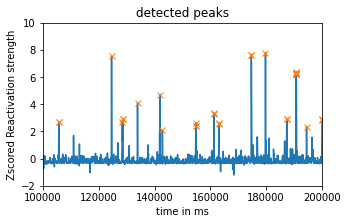

In [35]:
from scipy.signal import find_peaks

figure, axes = plt.subplots(nrows=1, ncols=1, figsize= (5,3))

zscoredR = scipy.stats.zscore(R_all_corr['drive/My Drive/NMA/Lederberg_2017-12-05'][0,0][:,0])
peaks, _ = scipy.signal.find_peaks(zscoredR,height = 2) # 2 std as threshold for peak detection
plt.plot(zscoredR)
plt.plot(peaks,zscoredR[peaks],'x')
plt.xlim([1e+5,2e+5])
plt.ylim([-2, 10])
plt.xlabel('time in ms')
plt.ylabel('Zscored Reactivation strength')
plt.title('detected peaks')
plt.savefig('drive/My Drive/NMA/ReactStrength_Peak_Detection.eps', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')

In [11]:

Rcorr = [0,1000,55] # peak amplitude, area, num component, 
Rincorr = [0,1000,55]


dates = ['05', '06', '07', '08', '09', '10']
st = 'drive/My Drive/NMA/Lederberg_2017-12-' 

numarea = 7
peaksHz1 = np.zeros((len(dates),numarea))
peaksHz2 = np.zeros((len(dates),numarea))

for session in range(len(dates)):
  print(session)
  keyname = st+dates[session]
  # numareas = len(R_all_corr[keyname].keys)/2

  for areaindx in range(7):
  # print('area ' + str(areaindx))
    try:
      shp = np.shape(R_all_corr[keyname][areaindx,0])
    
      for numcomponent in range(np.min([shp[1],2])):
        # numcomponent = 0
        try:
          temp1 = R_all_corr[keyname][areaindx,0][:,numcomponent]
          temp2 = R_all_incorr[keyname][areaindx,0][:,numcomponent]
          zscoredRcorr = scipy.stats.zscore(temp1)
          peaks1, _ = scipy.signal.find_peaks(zscoredRcorr,height = 2) # 2 std as threshold for peak detection
          zscoredRincorr = scipy.stats.zscore(temp2)
          peaks2, _ = scipy.signal.find_peaks(zscoredRincorr,height = 2) # 2 std as threshold for peak detection

          
          peaksHz1[session,areaindx] = len(temp1)/1000
          peaksHz2[session,areaindx] = len(temp2)/1000


          areaindxlong1 = areaindx * np.ones(len(peaks1))
          areaindxlong2 = areaindx * np.ones(len(peaks2))
          areaindxlong1 = areaindxlong1[:, np.newaxis]
          areaindxlong2 = areaindxlong2[:, np.newaxis]
          
          compindx1 = numcomponent * np.ones(len(peaks1))
          compindx1 = compindx1[:, np.newaxis]
          compindx2 = numcomponent * np.ones(len(peaks2))
          compindx2 = compindx2[:, np.newaxis]

          x_1 = temp1[peaks1]
          x_2 = temp2[peaks2]
          x_1 = x_1[:, np.newaxis]
          x_2 = x_2[:, np.newaxis]

          xx1 = np.append(x_1,areaindxlong1,axis=1)
          xx2 = np.append(x_2,areaindxlong2,axis=1)
          xx11 = np.append(xx1,compindx1,axis=1)
          xx22 = np.append(xx2,compindx2,axis=1)
          
          Rcorr = np.vstack((Rcorr,xx11) )
          Rincorr = np.vstack((Rincorr,xx22) )
        except KeyError:
          print('area has no neuron in area '+ str(areaindx) +'. skipped.')
    except KeyError:
        print('area has no results in area '+ str(areaindx) +'. skipped.')



0
area has no results in area 4. skipped.
area has no results in area 5. skipped.
area has no results in area 6. skipped.
1
area has no results in area 6. skipped.
2
area has no results in area 1. skipped.
area has no results in area 5. skipped.
area has no results in area 6. skipped.
3
area has no results in area 3. skipped.
4
area has no results in area 0. skipped.
area has no results in area 5. skipped.
area has no results in area 6. skipped.
5
area has no results in area 2. skipped.
area has no results in area 3. skipped.
area has no results in area 4. skipped.
area has no results in area 5. skipped.


In [12]:
peaksHz1[peaksHz1==0]=None
print(np.nanmean(peaksHz1,axis=0))
mean_rec_time_per_area_corr = np.nanmean(peaksHz1,axis=0)
peaksHz2[peaksHz2==0]=None
print(np.nanmean(peaksHz2,axis=0))
mean_rec_time_per_area_incorr = np.nanmean(peaksHz2,axis=0)

[381.649   396.2828  389.3242  354.55675 382.78625 481.215   405.48   ]
[100.7664   99.7316  111.8352  105.84225 107.09625 109.9645   91.052  ]


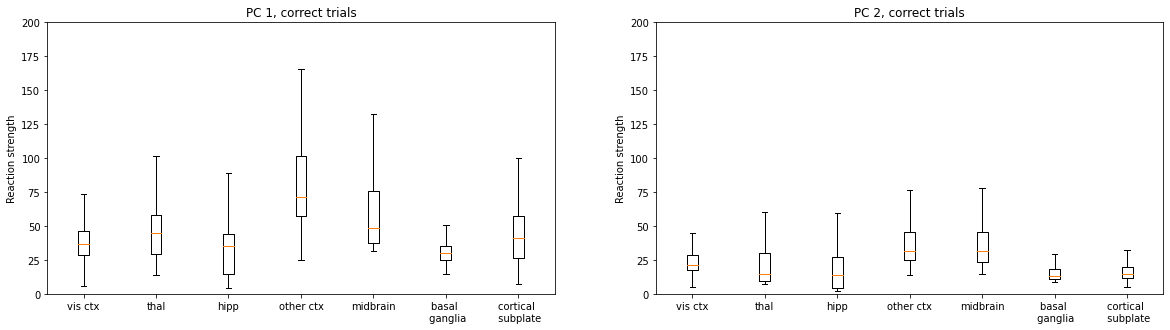

In [14]:
numpeakscomp1_corr = np.zeros(7)
numpeakscomp2_corr = np.zeros(7)

x = Rcorr
figure, axes = plt.subplots(nrows=1, ncols=2, figsize= (20,5))


ax = plt.subplot(121)
for i in range(7): # going through brain areas
  numpeakscomp1_corr[i] = np.sum(x[:,1]==i)
  xarea= x[x[:,1]==i,:]
  xtemp1 = xarea[xarea[:,2]==0,0]
  ax.boxplot(xtemp1, positions = [i+1],showfliers=False)
  ax.set_xlim(0.5, 7.5)

plt.xticks(ticks = np.arange(1,8), labels=["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal \n ganglia", "cortical \n subplate"]) 
plt.ylabel('Reaction strength')
plt.ylim([0,200])
plt.title('PC 1, correct trials')


ax = plt.subplot(122)
for i in range(7): # going through brain areas
  numpeakscomp2_corr[i] = np.sum(x[:,1]==i)
  xarea= x[x[:,1]==i,:]
  xtemp2 = xarea[xarea[:,2]==1,0]
  ax.boxplot(xtemp2, positions = [i+1],showfliers=False)
  ax.set_xlim(0.5, 7.5)

plt.xticks(ticks = np.arange(1,8), labels=["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal \n ganglia", "cortical \n subplate"]) 
plt.ylabel('Reaction strength')
plt.ylim([0,200])
plt.title('PC 2, correct trials')

plt.show()

# ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]

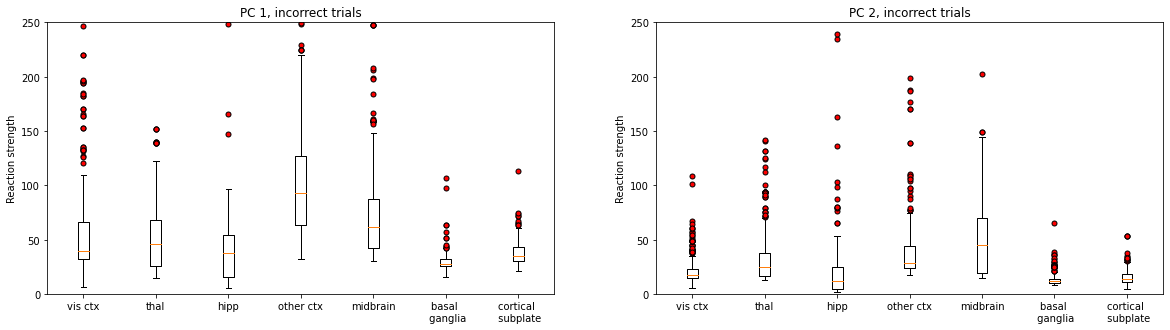

In [26]:
numpeakscomp1_incorr = np.zeros(7)
numpeakscomp2_incorr = np.zeros(7)


x = Rincorr
figure, axes = plt.subplots(nrows=1, ncols=2, figsize= (20,5))

ax = plt.subplot(121)
for i in range(7): # going through brain areas
  numpeakscomp1_incorr[i] = np.sum(x[:,1]==i)
  xarea= x[x[:,1]==i,:]
  xtemp1 = xarea[xarea[:,2]==0,0]
  ax.boxplot(xtemp1, positions = [i+1],showfliers=True, flierprops=flierprps)
  ax.set_xlim(0.5, 7.5)

plt.xticks(ticks = np.arange(1,8), labels=["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal \n ganglia", "cortical \n subplate"]) 
plt.ylabel('Reaction strength')
plt.ylim([0,250])
plt.title('PC 1, incorrect trials')

ax = plt.subplot(122)
for i in range(7): # going through brain areas
  numpeakscomp2_incorr[i] = np.sum(x[:,1]==i)
  xarea= x[x[:,1]==i,:]
  xtemp2 = xarea[xarea[:,2]==1,0]
  ax.boxplot(xtemp2, positions = [i+1],showfliers=True, flierprops=flierprps)
  ax.set_xlim(0.5, 7.5)

plt.xticks(ticks = np.arange(1,8), labels=["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal \n ganglia", "cortical \n subplate"]) 
plt.ylabel('Reaction strength')
plt.ylim([0,250])
plt.title('PC 2, incorrect trials')

plt.show()

Text(0, 0.5, '# peaks per second')

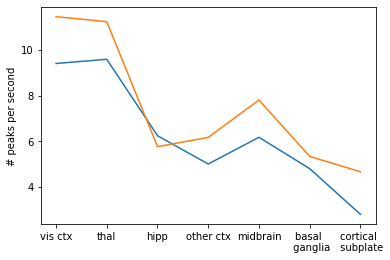

In [16]:
plt.plot(np.arange(1,len(numpeakscomp1_corr)+1),numpeakscomp1_corr/mean_rec_time_per_area_corr)
plt.plot(np.arange(1,len(numpeakscomp1_corr)+1),numpeakscomp2_incorr/mean_rec_time_per_area_incorr)
plt.xticks(ticks = np.arange(1,8), labels=["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal \n ganglia", "cortical \n subplate"]) 
plt.ylabel('# peaks per second')

2.261620337384297e-10
0.5722229525975358
0.0008594306580555516
4.862686235313306e-07
1.03893906499257e-06
0.005497028233122865
0.00892638716467933
[0.84206713 0.95684569 0.91806225 0.95388568 0.99626621 1.05100519
 1.13995393]


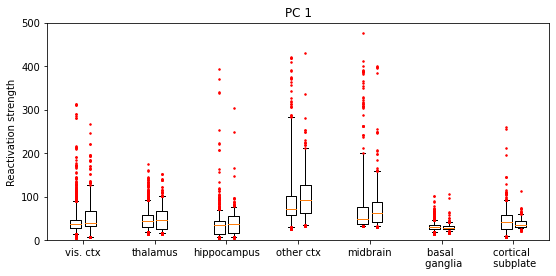

In [31]:
from scipy.stats import kruskal, ranksums

hyptest = np.zeros(7)
figure, axes = plt.subplots(nrows=1, ncols=1, figsize= (9,4))

flierprps = dict(marker='.', markerfacecolor='r', markersize=3,
                  linestyle='none', markeredgecolor='r')


xc = Rcorr
xic = Rincorr
ax = plt.subplot(111)
for i in range(7): # going through brain areas
  xarea= xc[xc[:,1]==i,:]
  xtemp1 = xarea[xarea[:,2]==0,0]
  ax.boxplot(xtemp1, positions = [i+0.90],showfliers=True,whis=(5,95),flierprops=flierprps)

  xarea= xic[xic[:,1]==i,:]
  xtemp2 = xarea[xarea[:,2]==0,0]
  ax.boxplot(xtemp2, positions = [i+1.1],showfliers=True,whis=(5,95),flierprops=flierprps)

  _,p = scipy.stats.ranksums(xtemp1,xtemp2)
  print(p)
  hyptest[i] = np.mean(xtemp1)/np.mean(xtemp2)

  ax.set_xlim(0.5, 7.5)

plt.xticks(ticks = np.arange(1,8), labels=["vis. ctx", "thalamus", "hippocampus", "other ctx", "midbrain", "basal \n ganglia", "cortical \n subplate"]) 
plt.ylabel('Reactivation strength')
plt.ylim([0,500])
plt.title('PC 1')

print(hyptest)
plt.savefig('drive/My Drive/NMA/ReactStrength_CorrIncorr_Boxplot.eps', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')


In [142]:
scipy.stats.kruskal(xtemp1,xtemp2)

KruskalResult(statistic=40.226478345228315, pvalue=2.2616203373844213e-10)